In [136]:
from datasets import load_dataset
import numpy as np
import xgboost as xgb

dataset = load_dataset(
    "hitorilabs/iris", 
    split="train", 
    )

# keep the int2str mapping to retrieve string labels
itos = dataset.features["species"].int2str

dataset = dataset.train_test_split(test_size=0.9, stratify_by_column="species")
X_train = dataset["train"].map(remove_columns=["species"]).to_pandas().to_numpy()
y_train = np.array(dataset["train"]["species"])

X_test = dataset["test"].map(remove_columns=["species"]).to_pandas().to_numpy()
y_test = np.array(dataset["test"]["species"])

# Create DMatrix for train and test
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

NUM_CLASSES = 3
# Set hyperparameters
params = {
    'objective': 'multi:softprob',
    'max_depth': 15,
    'learning_rate': 0.1,
    'num_class': NUM_CLASSES,
}

# Train the model
num_rounds = 100
bst = xgb.train(params, dtrain, num_rounds)

# Make predictions
preds = bst.predict(dtest)

acc = sum(dataset["test"]["species"] == preds.argmax(axis=1)) / len(dataset["test"])

print(f"""{acc:.2%} ({sum(dataset["test"]["species"] == preds.argmax(axis=1))}/{len(dataset["test"])})""")

Map: 100%|██████████| 135/135 [00:00<00:00, 11127.44 examples/s]

94.07% (127/135)


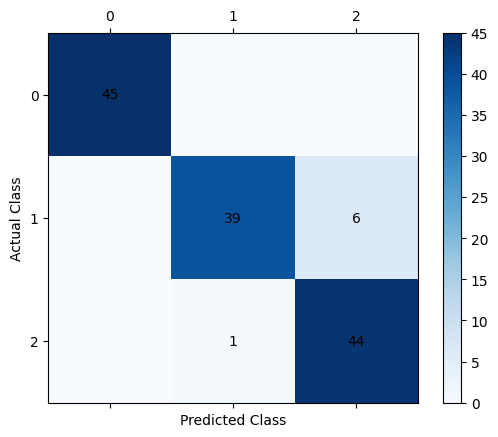

In [126]:
import matplotlib.pyplot as plt

from collections import Counter

fig, ax = plt.subplots()

pred_matrix = np.zeros((NUM_CLASSES, NUM_CLASSES))
for [x,y], count in Counter(zip(y_test,preds.argmax(axis=1))).items():
    pred_matrix[x,y] = count
    ax.text(y,x,  count, ha='center', va='center')

ax.set_xlabel('Predicted Class')
ax.set_ylabel('Actual Class')
fig.colorbar(ax.matshow(pred_matrix, cmap='Blues'))
fig.show()

In [120]:
def precision_recall_f1(y_true, y_pred, class_label):
    TP = np.sum((y_true == class_label) == (y_pred == class_label))
    FP = np.sum((y_true != class_label) == (y_pred == class_label))
    FN = np.sum((y_true == class_label) == (y_pred != class_label))
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    
    return class_label, precision, recall, f1

results = (precision_recall_f1(y_test, preds.argmax(axis=1), class_label) for class_label in range(NUM_CLASSES))

for class_label, precision, recall, f1 in results:
    print(f"Class {itos(class_label):<20} Precision: {precision:<8.2%} Recall: {recall:<8.2%} F1: {f1:<8.2%}")

Class Iris-setosa          Precision: 100.00%  Recall: 100.00%  F1: 100.00% 
Class Iris-versicolor      Precision: 94.81%   Recall: 94.81%   F1: 94.81%  
Class Iris-virginica       Precision: 94.81%   Recall: 94.81%   F1: 94.81%  
